In [558]:
import pandas as pd
import numpy as np
import gensim
from gensim.models import word2vec
import unicodedata

In [559]:
pd.set_option('display.max_colwidth', None)

In [632]:
!kaggle competitions download -c nlp-getting-started
!unzip nlp-getting-started.zip -d ../data/

nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  nlp-getting-started.zip
replace ../data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [560]:
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")
sample_submission = pd.read_csv("../data/sample_submission.csv")

## First look at the datasets

In [561]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1


In [562]:
train_df.location.value_counts(dropna=False,normalize=True)

NaN                               0.332720
USA                               0.013661
New York                          0.009326
United States                     0.006568
London                            0.005911
                                    ...   
Mississauga, Ontario              0.000131
3?3?7?SLOPelousas??2?2?5?         0.000131
Massachusetts                     0.000131
Online 24/7. Not even kidding.    0.000131
North Ferriby, East Yorkshire     0.000131
Name: location, Length: 3342, dtype: float64

In [563]:
train_df.keyword.value_counts(dropna=False,normalize=True)

NaN                      0.008013
fatalities               0.005911
armageddon               0.005517
deluge                   0.005517
sinking                  0.005386
                           ...   
forest%20fire            0.002496
epicentre                0.001576
threat                   0.001445
inundation               0.001314
radiation%20emergency    0.001182
Name: keyword, Length: 222, dtype: float64

In [564]:
train_df.target.value_counts(dropna=False,normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

## Preprocessing

In [565]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer 
import re
lem = WordNetLemmatizer()
tokenizer = TweetTokenizer()

In [604]:
def decontracted(phrase:str) -> str:
    # specific
    phrase = re.sub(r"wont", "will not", phrase)
    phrase = re.sub(r"cant", "can not", phrase)
    phrase = re.sub(r"wasnt", "was not", phrase)
    phrase = re.sub(r"werent", "were not", phrase)
    phrase = re.sub(r"ppl", "people", phrase)
    phrase = re.sub(r"wht", "what", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def remove_accented_chars(text: str) -> str:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_noise(sentence:str) -> str:
    sentence = re.sub(r"@", " ", sentence)
    sentence = re.sub(r"https?:\/\/\S+", " ", sentence)
    sentence = re.sub(r"[0-9]+", " ", sentence)
    return sentence

noise_words_list = ["utc","amp"]
    
def preprocess_sentence(sentence: str) -> list:
    sentence = sentence.lower()
    sentence = re.sub(r"#", ' ', sentence)
    sentence = remove_noise(sentence)
    sentence = decontracted(sentence)
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    regex = re.compile('([^\s\w]|_)+')
    cleantext = regex.sub(' ', cleantext)
    cleantext = remove_accented_chars(cleantext)
    tokens = tokenizer.tokenize(cleantext)
    tokens_normalized = [word for word in tokens if len(word)>2 and word not in stopwords.words('english')]
    tokens_lemmatized = [lem.lemmatize(word) for word in tokens_normalized if word not in noise_words_list]
    return tokens_lemmatized

In [605]:
def preprocess_df(df: pd.DataFrame ) -> pd.DataFrame:
    df.loc[df.keyword.isna(), "keyword"] = ""
    df.loc[df.location.isna(), "location"] = ""
    df["keyword"] = df["keyword"].astype(str)
    df["location"] = df["location"].astype(str) 
    #df["text"] = df["text"] + " " + df["keyword"].astype("str")
    df["tokens"] = df["text"].map(lambda x: preprocess_sentence(x))
    df["features"] = df.tokens.apply(lambda x: " ".join(x))
    return df

In [606]:
train_df = preprocess_df(train_df)

In [607]:
train_df

,id,keyword,location,text,target,tokens,features
0,1,,,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,"[deed, reason, earthquake, may, allah, forgive]",deed reason earthquake may allah forgive
1,4,,,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, ronge, sask, canada]",forest fire near ronge sask canada
2,5,,,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,"[resident, asked, ishelter, place, notified, officer, evacuation, shelter, place, order, expected]",resident asked ishelter place notified officer evacuation shelter place order expected
3,6,,,"13,000 people receive #wildfires evacuation orders in California",1,"[people, receive, wildfire, evacuation, order, california]",people receive wildfire evacuation order california
4,7,,,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,"[got, sent, photo, ruby, alaska, smoke, wildfire, pours, school]",got sent photo ruby alaska smoke wildfire pours school
...,...,...,...,...,...,...,...
7608,10869,,,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,"[two, giant, crane, holding, bridge, collapse, nearby, home]",two giant crane holding bridge collapse nearby home
7609,10870,,,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,"[aria, ahrary, thetawniest, control, wild, fire, california, even, northern, part, state, troubling]",aria ahrary thetawniest control wild fire california even northern part state troubling
7610,10871,,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,"[volcano, hawaii]",volcano hawaii
7611,10872,,,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,"[police, investigating, bike, collided, car, little, portugal, bike, rider, suffered, serious, non, life, threatening, injury]",police investigating bike collided car little portugal bike rider suffered serious non life threatening injury


In [608]:
terms_frequency = pd.DataFrame({"word": [item for sublist in np.array(train_df.tokens).tolist() for item in sublist ]})

In [609]:
train_df[train_df.features.str.contains("amp")]

,id,keyword,location,text,target,tokens,features
11,17,,,Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding,1,"[haha, south, tampa, getting, flooded, hah, wait, second, live, south, tampa, gonna, gonna, fvck, flooding]",haha south tampa getting flooded hah wait second live south tampa gonna gonna fvck flooding
12,18,,,#raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I've lost count,1,"[raining, flooding, florida, tampabay, tampa, day, lost, count]",raining flooding florida tampabay tampa day lost count
55,79,ablaze,USA,#Kurds trampling on Turkmen flag later set it ablaze while others vandalized offices of Turkmen Front in #Diyala http://t.co/4IzFdYC3cg,1,"[kurd, trampling, turkmen, flag, later, set, ablaze, others, vandalized, office, turkmen, front, diyala]",kurd trampling turkmen flag later set ablaze others vandalized office turkmen front diyala
74,107,accident,North Carolina,I-77 Mile Marker 31 South Mooresville Iredell Vehicle Accident Ramp Closed at 8/6 1:18 PM,1,"[mile, marker, south, mooresville, iredell, vehicle, accident, ramp, closed]",mile marker south mooresville iredell vehicle accident ramp closed
144,208,airplane%20accident,"Eagle Pass, Texas",A Cessna airplane accident in Ocampo Coahuila Mexico on July 29 2015 killed four men including a State of Coahuila government official.,1,"[cessna, airplane, accident, ocampo, coahuila, mexico, july, killed, four, men, including, state, coahuila, government, official]",cessna airplane accident ocampo coahuila mexico july killed four men including state coahuila government official
...,...,...,...,...,...,...,...
7159,10258,war%20zone,"Downtown Churubusco, Indiana",Camping in a war zone with roving raccoons toughens city slicker http://t.co/oJuS08yZrq,0,"[camping, war, zone, roving, raccoon, toughens, city, slicker]",camping war zone roving raccoon toughens city slicker
7272,10411,whirlwind,140920-21 & 150718-19 BEIJING,{INFO} Baekhyun and Suho will be attending the Idol Sports Championship on August 10th\nCr: SYJEXO \n http://t.co/oAZjPwUeYR,0,"[info, baekhyun, suho, attending, idol, sport, championship, august, syjexo]",info baekhyun suho attending idol sport championship august syjexo
7311,10464,wild%20fires,"Johannesburg, South Africa",They should just have load shedding permanently and we will all just live like we in the wild and have camp fires cook with fire etc,0,"[load, shedding, permanently, live, like, wild, camp, fire, cook, fire, etc]",load shedding permanently live like wild camp fire cook fire etc
7393,10580,windstorm,(a) property of the universe,the windstorm blew thru my open window and now my bong is in pieces just another example of nature's indifference to human suffering,0,"[windstorm, blew, thru, open, window, bong, piece, another, example, nature, indifference, human, suffering]",windstorm blew thru open window bong piece another example nature indifference human suffering


In [610]:
terms_frequency.value_counts().head(50)

word      
fire          356
like          350
get           255
new           227
via           220
people        218
news          211
one           208
would         191
time          181
year          178
video         175
disaster      162
emergency     159
body          155
day           151
home          144
police        143
building      141
family        132
life          132
say           131
still         129
storm         128
crash         125
back          122
california    121
burning       121
bomb          121
know          120
look          120
world         117
train         116
flood         115
man           115
car           115
suicide       114
got           114
death         114
see           112
attack        110
first         109
love          106
two           104
going         104
nuclear       104
today         102
make          102
let           102
war           102
dtype: int64

# Text to features

## Bag of Words

In [571]:
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [572]:
#vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,3))
vectorizer = feature_extraction.text.TfidfVectorizer()

In [573]:
corpus = train_df.features.to_list()
vectorizer = vectorizer.fit(corpus)
X = vectorizer.transform(train_df.features.to_list()) 

In [574]:
y = train_df["target"].to_list()

In [575]:
train, test = train_test_split(train_df, test_size=0.2, random_state=0)

In [576]:
y_train = train["target"].to_list()
y_test = test["target"].to_list()

In [577]:
X_train = X[train.index]
X_test = X[test.index]

### dimension reduction

In [578]:
from sklearn import feature_selection, pipeline, naive_bayes

In [579]:
corpus = train.features.to_list()

In [580]:
X_names = vectorizer.get_feature_names()
reduce_dimension = False
if reduce_dimension:
    p_value_limit = 0.95
    dtf_features = pd.DataFrame()
    for cat in np.unique(y):
        chi2, p = feature_selection.chi2(X_train, y_train==cat)
        dtf_features = dtf_features.append(pd.DataFrame(
                       {"feature":X_names, "score":1-p, "y":cat}))
        dtf_features = dtf_features.sort_values(["y","score"], 
                        ascending=[True,False])
        dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
    
    X_names = dtf_features["feature"].unique().tolist()
    vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
    vectorizer.fit(corpus)

In [581]:
X_train = vectorizer.transform(corpus)

In [582]:
classifier = RandomForestClassifier(n_estimators=2000, random_state=0)
#classifier = naive_bayes.MultinomialNB()

In [583]:
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
model["classifier"].fit(X_train, y_train)

RandomForestClassifier(n_estimators=2000, random_state=0)

In [584]:
X_test = test["features"].values
predicted = model.predict(X_test)
y_pred = model.predict(X_test)

In [585]:
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85       886
           1       0.86      0.64      0.73       637

    accuracy                           0.81      1523
   macro avg       0.82      0.78      0.79      1523
weighted avg       0.81      0.81      0.80      1523

0.8056467498358503


In [586]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

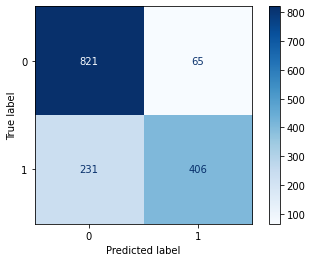

In [587]:
plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=["0", "1"],
                                 cmap=plt.cm.Blues)

In [588]:
test.loc[:,"prediction"] = y_pred

/Users/diego.garcia/.local/share/virtualenvs/kaggle-nlp-disaster-tweets-oFUYpqth/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/diego.garcia/.local/share/virtualenvs/kaggle-nlp-disaster-tweets-oFUYpqth/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [589]:
test[test["target"] != test["prediction"]]

,id,keyword,location,text,target,tokens,features,prediction
5056,7205,natural%20disaster,USA,Coming later this year~ 'THE MAN THAT TATTOOED WOMEN.' A novel based on a real serial killer from #Arkansas &amp; a natural disaster. #NOLA,1,"[coming, later, year, nothe, man, tattooed, woman, novel, based, real, serial, killer, arkansas, amp, natural, disaster, nola]",coming later year nothe man tattooed woman novel based real serial killer arkansas amp natural disaster nola,0
1531,2213,chemical%20emergency,Ukraine and Ireland,Russian nuclear-biological-chemical (NBC) brigade 'emergency response' exercise in Southern MD http://t.co/Ul5XdblmBk http://t.co/VjHpVLnbaw,1,"[russian, nuclear, biological, chemical, nbc, brigade, emergency, response, exercise, southern, xdblmbk]",russian nuclear biological chemical nbc brigade emergency response exercise southern xdblmbk,0
5629,8029,refugees,,Short of throwing them overboard himself I don't think any other leader could do much worse by #refugees than @TonyAbbottMHR worst pm ever!,1,"[short, throwing, overboard, think, leader, could, much, worse, refugee, tonyabbottmhr, worst, ever]",short throwing overboard think leader could much worse refugee tonyabbottmhr worst ever,0
4585,6519,injuries,Carterville,Carterville High School coaches prepare for game-day injuries http://t.co/kKiMMBUe04,1,"[carterville, high, school, coach, prepare, game, day, injury]",carterville high school coach prepare game day injury,0
5789,8259,rioting,trapped in America,@evacide The Ferguson RIOTS worked. This of this the next time you say RIOTING doesn't change anything.\n\nThere fixed it for you.,1,"[evacide, ferguson, riot, worked, next, time, say, rioting, change, anything, fixed]",evacide ferguson riot worked next time say rioting change anything fixed,0
...,...,...,...,...,...,...,...,...
3212,4608,emergency%20services,,We're #hiring! Click to apply: RN II/EMERGENCY SERVICES/FT/7P-7A - http://t.co/NV3Uxv9IMX #Nursing #Houston TX http://t.co/ej30IhrEA9,1,"[hiring, click, apeopley, emergency, service, uxv, imx, nursing, houston, ihrea]",hiring click apeopley emergency service uxv imx nursing houston ihrea,0
3894,5538,flattened,"Chorley, Lancashire, UK",Fylde Building set to be flattened: One of PrestonÛªs city centre iconic buildings is disappearing from the skyline. http://t.co/PdKHBdG9hO,0,"[fylde, building, set, flattened, one, preston, uas, city, centre, iconic, building, disappearing, skyline]",fylde building set flattened one preston uas city centre iconic building disappearing skyline,1
7175,10283,war%20zone,ca(NADA),THIS IS A ONE DIRECTION CONCERT NOT A WAR ZONE WHAT IS THIS #OTRAMETLIFE http://t.co/PtY9HRCUZH,1,"[one, direction, concert, war, zone, otrametlife, hrcuzh]",one direction concert war zone otrametlife hrcuzh,0
3728,5299,fear,,Nothing to fear. It's all about taking risks.,1,"[nothing, fear, taking, risk]",nothing fear taking risk,0


# Prediction

In [312]:
test_df = preprocess_df(test_df)

In [313]:
X_test = vectorizer_fit.transform(test_df.features.to_list()) 
y_test = classifier.predict(X_test)
#test_df['target'] = 

In [28]:
y_test

array([1, 1, 1, ..., 1, 1, 0])

In [314]:
test_df["target"] = y_test

# Submission

In [315]:
sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [316]:
submission = test_df[["id","target"]]

In [317]:
#submission.to_csv("submission.csv",index=False)

In [319]:
#!kaggle competitions submit -f submission.csv -m "BoW and TIDF improved token cleaner" nlp-getting-started

100%|██████████████████████████████████████| 22.2k/22.2k [00:02<00:00, 9.17kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

In [320]:
#!kaggle competitions submissions nlp-getting-started

fileName        date                 description                          status    publicScore  privateScore  
--------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission.csv  2021-03-05 14:45:06  BoW and TIDF improved token cleaner  complete  0.78761      None          
submission.csv  2021-03-04 10:12:31  BoW and TIDF                         complete  0.78639      None          


In [620]:
!pwd

/Users/diego.garcia/learning/kaggle/kaggle-nlp-disaster-tweets/notebooks
